In [1]:
# Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [2]:
# Model imports
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
# Evaluation imports
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from statistics import mean, stdev

In [5]:
X_train_df = pd.read_csv('X_train.csv')
X_test_df = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_test_df = pd.read_csv('y_test.csv')
stock_data_train_df = pd.read_csv('stock_data_train.csv')
stock_data_test_df = pd.read_csv('stock_data_test.csv')

In [6]:
X_train_np = X_train_df.to_numpy()
X_test_np = X_test_df.to_numpy()
y_train_np = y_train_df.to_numpy()
y_test_np = y_test_df.to_numpy()
stock_data_train_np = stock_data_train_df.to_numpy()
stock_data_test_np = stock_data_test_df.to_numpy()

In [7]:
ts = 1 # number of time steps

In [8]:
X_train = np.reshape(X_train_np, (int(X_train_np.shape[0]/ts), ts, X_train_np.shape[1]))
X_test = np.reshape(X_test_np, (int(X_test_np.shape[0]/ts), ts, X_test_np.shape[1]))
y_train = y_train_df[::ts]
y_test = y_test_df[::ts]
stock_data_train = np.reshape(stock_data_train_np, (int(stock_data_train_np.shape[0]/ts), ts, stock_data_train_np.shape[1]))
stock_data_test = np.reshape(stock_data_test_np, (int(stock_data_test_np.shape[0]/ts), ts, stock_data_test_np.shape[1]))

In [57]:
def lstm(ts, num_features, train_X, train_Y, test_X,
         h_units=10,
         a_func=None, 
         train_alg='RMSProp', 
         b_s=32,
         e=50):
    
    train_scaler = StandardScaler()
    train_Y_final = train_scaler.fit_transform(train_Y)
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(h_units, input_shape=(ts, num_features), return_sequences=False, dropout=0.2))
    model.add(Dense(1, activation=a_func))
    model.compile(loss='mse', optimizer=train_alg, metrics=['mse', 'mae'])
    
    model.fit(train_X, train_Y_final, epochs=e, verbose=0, batch_size=b_s)
    pred_Y = model.predict(test_X)
        
    return train_scaler, pred_Y

In [10]:
# SELECTING BEST NUMBER OF LSTM CELLS

In [11]:
actual_labels = []
for i in range(len(y_test_np)):
    if i==0:
        continue
    
    if y_test_np[i] >= y_test_np[i-1]:
        actual_labels.append(1)
    else:
        actual_labels.append(0)

In [12]:
def get_labels(pred_open):
    observed_labels = []
    for i in range(len(pred_open)):
        if i==0:
            continue

        if pred_open[i] >= pred_open[i-1]:
            observed_labels.append(1)
        else:
            observed_labels.append(0)
    
    return observed_labels

In [67]:
combined = {'5':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '10':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '15':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '20':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '25':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}}

In [68]:
y_test = y_test.reset_index(drop=True)

cells = [5, 10, 15, 20, 25]
repeats = 5
print('Combined Stock and news topic data')

for num_cells in cells:
    temp = {'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[[], [], [], []]}
    
    for i in range(repeats):
        train_scaler, pred_Y = lstm(ts, 29, X_train, y_train, X_test, num_cells)
        pred_Y_inversed = train_scaler.inverse_transform(pred_Y)
        
        labels = get_labels(pred_Y_inversed)

        r2 = r2_score(y_test['Adj Close'], pred_Y_inversed)
        mse = mean_squared_error(y_test['Adj Close'], pred_Y_inversed)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test['Adj Close'], pred_Y_inversed)
        accuracy = accuracy_score(np.array(actual_labels), np.array(labels))
        cm = confusion_matrix(np.array(actual_labels), np.array(labels))
        
        temp['r2'].append(r2)
        temp['mse'].append(mse)
        temp['rmse'].append(rmse)
        temp['mae'].append(mae)
        temp['acc'].append(accuracy)
        # cm: [[0], [1]
        #      [2], [3]
        temp['cm'][0].append(cm[0][0])
        temp['cm'][1].append(cm[0][1])
        temp['cm'][2].append(cm[1][0])
        temp['cm'][3].append(cm[1][1])
        
    combined[str(num_cells)]['r2'].append([mean(temp['r2']), stdev(temp['r2'])])
    combined[str(num_cells)]['mse'].append([mean(temp['mse']), stdev(temp['mse'])])
    combined[str(num_cells)]['rmse'].append([mean(temp['rmse']), stdev(temp['rmse'])])
    combined[str(num_cells)]['mae'].append([mean(temp['mae']), stdev(temp['mae'])])
    combined[str(num_cells)]['acc'].append([mean(temp['acc']), stdev(temp['acc'])])
    combined[str(num_cells)]['cm'].append([[mean(temp['cm'][0]), stdev(temp['cm'][0])], 
                                           [mean(temp['cm'][1]), stdev(temp['cm'][1])], 
                                           [mean(temp['cm'][2]), stdev(temp['cm'][2])], 
                                           [mean(temp['cm'][3]), stdev(temp['cm'][3])]])

Combined Stock and news topic data


In [69]:
stock = {'5':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '10':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '15':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '20':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}
            , '25':{'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[]}}

In [70]:
print('Stock data')

for num_cells in cells:
    temp = {'r2':[], 'mse':[], 'rmse':[], 'mae':[], 'acc':[], 'cm':[[], [], [], []]}
    
    for i in range(repeats):
        train_scaler, pred_Y = lstm(ts, 4, stock_data_train, y_train, stock_data_test, num_cells)
        pred_Y_inversed = train_scaler.inverse_transform(pred_Y)
        
        labels = get_labels(pred_Y_inversed)

        r2 = r2_score(y_test['Adj Close'], pred_Y_inversed)
        mse = mean_squared_error(y_test['Adj Close'], pred_Y_inversed)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test['Adj Close'], pred_Y_inversed)
        accuracy = accuracy_score(np.array(actual_labels), np.array(labels))
        cm = confusion_matrix(np.array(actual_labels), np.array(labels))
        
        temp['r2'].append(r2)
        temp['mse'].append(mse)
        temp['rmse'].append(rmse)
        temp['mae'].append(mae)
        temp['acc'].append(accuracy)
        # cm: [[0], [1]
        #      [2], [3]
        temp['cm'][0].append(cm[0][0])
        temp['cm'][1].append(cm[0][1])
        temp['cm'][2].append(cm[1][0])
        temp['cm'][3].append(cm[1][1])
        
    stock[str(num_cells)]['r2'].append([mean(temp['r2']), stdev(temp['r2'])])
    stock[str(num_cells)]['mse'].append([mean(temp['mse']), stdev(temp['mse'])])
    stock[str(num_cells)]['rmse'].append([mean(temp['rmse']), stdev(temp['rmse'])])
    stock[str(num_cells)]['mae'].append([mean(temp['mae']), stdev(temp['mae'])])
    stock[str(num_cells)]['acc'].append([mean(temp['acc']), stdev(temp['acc'])])
    stock[str(num_cells)]['cm'].append([[mean(temp['cm'][0]), stdev(temp['cm'][0])], 
                                           [mean(temp['cm'][1]), stdev(temp['cm'][1])], 
                                           [mean(temp['cm'][2]), stdev(temp['cm'][2])], 
                                           [mean(temp['cm'][3]), stdev(temp['cm'][3])]])

Stock data


In [72]:
pd.DataFrame(combined)

,5,10,15,20,25
r2,"[[-65.5758496710678, 0.8004254655127211]]","[[-66.24872552212629, 1.0327863714864183]]","[[-66.1945355739617, 0.620441692376284]]","[[-66.58951633995038, 0.7185543190208494]]","[[-67.88125722898651, 2.133688284155018]]"
mse,"[[25408871.10017848, 305484.7602996705]]","[[25665676.170642316, 394165.9913733492]]","[[25644994.41570201, 236793.41780322115]]","[[25795740.00016907, 274238.3936620118]]","[[26288736.753594097, 814328.4816929067]]"
rmse,"[[5040.648288159362, 30.330167625989734]]","[[5066.01095239923, 38.878027428180324]]","[[5064.045667691353, 23.342323107745997]]","[[5078.893300772259, 26.991654722822805]]","[[5126.760016089465, 79.59656886794228]]"
mae,"[[4699.50746477497, 28.679646517193092]]","[[4733.184167134423, 50.45659151682456]]","[[4728.489510501649, 26.99911875084331]]","[[4758.801695449828, 38.98047471218688]]","[[4814.515921855293, 101.99445951704368]]"
acc,"[[0.45994962216624685, 0.0028719784007535036]]","[[0.4513853904282116, 0.007845043578033973]]","[[0.4609571788413098, 0.00925499902814802]]","[[0.4579345088161209, 0.004845184902184217]]","[[0.45994962216624685, 0.014426016184661323]]"
cm,"[[[78, 1.7320508075688772], [116, 1.7320508075...","[[[76, 2.0], [118, 2.0], [99, 2.23606797749979...","[[[79, 3.0], [116, 3.0], [98, 1.41421356237309...","[[[78, 1.4142135623730951], [117, 1.4142135623...","[[[79, 2.23606797749979], [115, 2.236067977499..."


In [95]:
combined['5']['cm']

[[[78, 1.7320508075688772],
  [116, 1.7320508075688772],
  [98, 1.4142135623730951],
  [104, 1.4142135623730951]]]

In [71]:
pd.DataFrame(stock)

,5,10,15,20,25
r2,"[[-66.71373149727731, 0.4523328857046314]]","[[-67.13456122982412, 0.7546342035305117]]","[[-66.73856503163482, 0.9361756039498226]]","[[-66.70496832920297, 0.7534296095826943]]","[[-67.85459341311969, 0.9672194637842885]]"
mse,"[[25843147.084521763, 172634.19158787525]]","[[26003758.003980312, 288008.3889282356]]","[[25852624.876792822, 357294.2045113705]]","[[25839802.59535444, 287548.6520641998]]","[[26278560.42893964, 369142.1859773715]]"
rmse,"[[5083.5929383808325, 16.95292623333182]]","[[5099.325346256752, 28.262541547304878]]","[[5084.450399074408, 35.16063396967441]]","[[5083.223731406972, 28.26419588965139]]","[[5126.160963733036, 35.95488213084468]]"
mae,"[[4734.727119199436, 21.74927597072202]]","[[4763.7419315424, 24.88303460589121]]","[[4770.374852740186, 40.19085617084307]]","[[4755.169825651618, 42.61058892817455]]","[[4820.548613634502, 46.757021979122456]]"
acc,"[[0.4634760705289673, 0.003562250786833996]]","[[0.4664987405541562, 0.0037361201446325727]]","[[0.47002518891687656, 0.0057989241477185505]]","[[0.4690176322418136, 0.007213008092330652]]","[[0.46448362720403025, 0.005518615188968917]]"
cm,"[[[79, 0.0], [115, 0.0], [97, 0.0], [104, 0.0]]]","[[[80, 1.4142135623730951], [114, 1.4142135623...","[[[82, 1.7320508075688772], [113, 1.7320508075...","[[[80, 2.0], [114, 2.0], [96, 1.0], [105, 1.0]]]","[[[80, 2.0], [114, 2.0], [98, 2.23606797749979..."


In [96]:
stock['5']['cm']

[[[79, 0.0], [115, 0.0], [97, 0.0], [104, 0.0]]]

In [97]:
train_scaler, pred_Y5c = lstm(ts, 29, X_train, y_train, X_test, 5)
pred_Y5c_inversed = train_scaler.inverse_transform(pred_Y5c)
r2_score(y_test['Adj Close'], pred_Y5c_inversed)

-66.40483036010495

In [99]:
train_scaler, pred_Y5sd = lstm(ts, 4, stock_data_train, y_train, stock_data_test, 5)
pred_Y5sd_inversed = train_scaler.inverse_transform(pred_Y5sd)
r2_score(y_test['Adj Close'], pred_Y5sd_inversed)

-65.40381334081968

In [89]:
dates = pd.read_csv('dates.csv')
dates['Date'] = pd.to_datetime(dates['Date']) 
dates = dates.reset_index(drop=True)

Text(0, 0.5, 'Adjacent Closing Price')

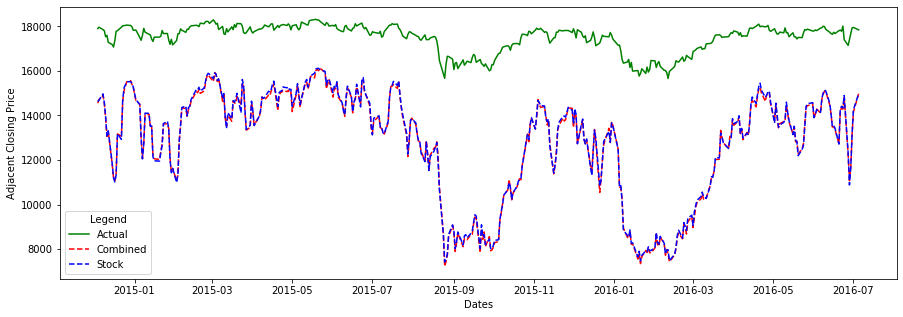

In [100]:
plt.figure(figsize=(15,5))
plt.plot(dates['Date'], y_test['Adj Close'], color='g', label='Actual')
plt.plot(dates['Date'],pred_Y5c_inversed, '--', color='r', label='Combined')
plt.plot(dates['Date'],pred_Y5sd_inversed, '--', color='b', label='Stock')
plt.legend(loc='best', title='Legend')
plt.xlabel('Dates')
plt.ylabel('Adjacent Closing Price')

[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

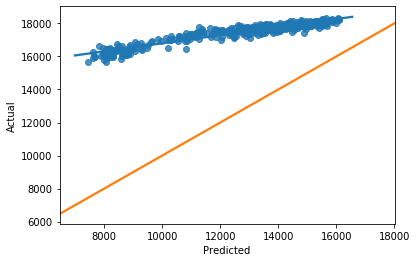

In [92]:
ax = sns.regplot(x=pred_Y5c_inversed, y=y_test['Adj Close'])
sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

[Text(0, 0.5, 'Actual'), Text(0.5, 0, 'Predicted')]

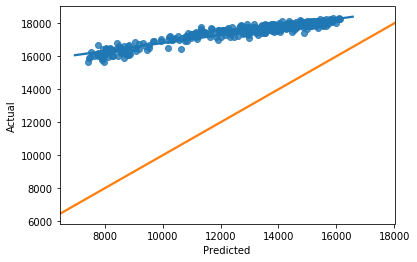

In [101]:
ax = sns.regplot(x=pred_Y5sd_inversed, y=y_test['Adj Close'])
sns.regplot(x=y_test['Adj Close'], y=y_test['Adj Close'], scatter=False, fit_reg=True)
ax.set(xlabel='Predicted', ylabel='Actual')

In [111]:
X_train_np25 = X_train_df.iloc[:,:25].to_numpy()
X_test_np25 = X_test_df.iloc[:,:25].to_numpy()
X_train25 = np.reshape(X_train_np25, (int(X_train_np25.shape[0]/ts), ts, X_train_np25.shape[1]))
X_test25 = np.reshape(X_test_np25, (int(X_test_np25.shape[0]/ts), ts, X_test_np25.shape[1]))

train_scaler, pred_Y5t = lstm(ts, 25, X_train25, y_train, X_test25, 5)
pred_Y5t_inversed = train_scaler.inverse_transform(pred_Y5t)
r2_score(y_test['Adj Close'], pred_Y5t_inversed)

-66.28308532045354

Text(0, 0.5, 'Adjacent Closing Price')

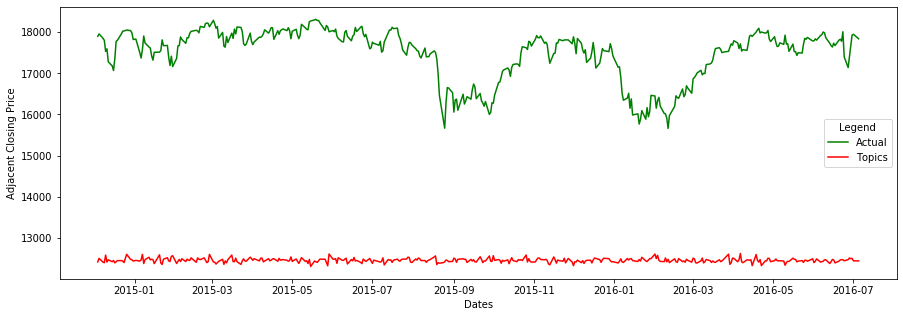

In [113]:
plt.figure(figsize=(15,5))
plt.plot(dates['Date'], y_test['Adj Close'], color='g', label='Actual')
plt.plot(dates['Date'],pred_Y5t_inversed, color='r', label='Topics')
plt.legend(loc='best', title='Legend')
plt.xlabel('Dates')
plt.ylabel('Adjacent Closing Price')

In [114]:
pred_Y5c_inversed.mean()

12751.5205

In [115]:
pred_Y5sd_inversed.mean()

12794.0205

In [116]:
pred_Y5t_inversed.mean()

12453.573